In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/churn_data.csv')

In [3]:
#change dtype of 'TotalCharges' from object to numeric
#if there is an error, because the value has a space (" "), we use --> errors='coerce'
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [4]:
#getting null (missing) values
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [5]:
#set missing values to zero
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [6]:
#column names & string values: lowercasing everything and replace spaces with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes


In [8]:
#change target variable from object to integer (if yes, then 1; if no, then 0)
df.churn = (df.churn == 'yes').astype(int)

In [9]:
#splitting the dataset in different subsets
from sklearn.model_selection import train_test_split


In [10]:
#shuffling the data of df and splitting it into 2 sets
#df_train_full (80%), df_test(20%)
#random_state guarantees that the data is always shuffled in the same way
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
#take df_train_full and split it into train and val
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)
#save target variable in a matrix array
y_train = df_train.churn.values
y_val = df_val.churn.values
#delete target variable from training and validation set
del df_train['churn']
del df_val['churn']

<b>Feature Engineering</b><br>
We compare 3 scenarios:<br>
* Scenario 1: All features are included 
* Scenario 2: The two least important features 'gender' and 'phoneservice' are excluded
* Scenario 3: The most important feature 'contract' is exluded<br><br>
The cell below gives the accuracy for each Scenario


In [12]:
#create variable lists
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

categ_ex_1 = ['seniorcitizen', 'partner', 'dependents',
'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

categ_ex_2 = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

lists = [categorical, categ_ex_1, categ_ex_2]
scenario = ['Scenario 1:', 'Scenario 2:', 'Scenario 3:']

In [13]:
x = 0
for L in lists:
    def prepare_X(df, categ):
        #convert training set to dictionary
        train_dict = df[categ + numerical].to_dict(orient='rows')
        from sklearn.feature_extraction import DictVectorizer
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)
        #use 'transform' method to convert dictionaries to matrix
        X = dv.transform(train_dict)
        return X
    
    #train logictic regression model
    from sklearn.linear_model import LogisticRegression
    #train model by calling the 'fit' method
    #X_train is derived from training set (besides we also have validation and testing set)
    model = LogisticRegression(solver='liblinear', random_state = 1)
    model.fit(prepare_X(df_train, L), y_train)
    
    def prepare_val(df, categ):
        #convert training set to dictionary
        train_dict = df[categ + numerical].to_dict(orient='rows')
        from sklearn.feature_extraction import DictVectorizer
        dv_new = DictVectorizer(sparse=False)
        dv_new.fit(train_dict)
        #use 'transform' method to convert dictionaries to matrix
        X = dv_new.transform(train_dict)
        return X
    
    #use the model to predict the target variable
    y_pred = model.predict_proba(prepare_val(df_val, L))[:, 1]
    y_pred >= 0.5
    churn = y_pred >= 0.5
    print('Accuracy for', scenario[x], (y_val == churn).mean())
    x += 1

Accuracy for Scenario 1: 0.8016129032258065
Accuracy for Scenario 2: 0.8026881720430108
Accuracy for Scenario 3: 0.7973118279569893


In [14]:
from sklearn.metrics import accuracy_score

In [15]:
#loop over different thresholds and see what has the best accuracy
#a threshold of 0.5 gives us the best accuracy
thresholds = np.linspace(0, 1, 11) #this gives 11 numbers starting with 0.0, 0.1, 0.2, ...
for t in thresholds:
    #compute accuracy
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    #print results
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.563
0.20 0.697
0.30 0.751
0.40 0.791
0.50 0.797
0.60 0.791
0.70 0.778
0.80 0.748
0.90 0.739
1.00 0.739


In [16]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)

Text(0, 0.5, 'Threshold')

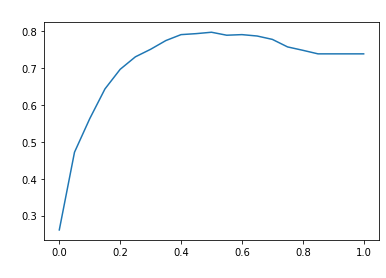

In [17]:
plt.plot(thresholds, accuracies)
plt.title('Threshold vs Accuracy', color='white')
plt.xlabel('Threshold', color='white')
plt.ylabel('Accurary', color='white')

Applying that to small model

In [18]:
small_subset = ['contract', 'tenure', 'totalcharges']
#convert to dictionary
train_dict_small = df_train[small_subset].to_dict(orient='rows')
#make use of DictVectorizer to perform one hot encoding
from sklearn.feature_extraction import DictVectorizer
dv_small = DictVectorizer(sparse=False)
#use fit method to apply DictVectorizer to dictionary
dv_small.fit(train_dict_small)
#transform dictionary to matrix array
X_small_train = dv_small.transform(train_dict_small)


In [19]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

#train a simpler model
#apply one-hot-encoding to validation set
val_dict_small = df_val[small_subset].to_dict(orient='rows')
dv_small.fit(val_dict_small)
X_small_val = dv_small.transform(val_dict_small)
#predict churn using this small model
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
churn_small = y_pred_small >= 0.5
#calculate accuracy
accuracy_score(y_val, churn_small)

0.7672043010752688

Is an accuracy of 0.77 now a good value? We need to compare it. One possibility could be<br>
the <b>Dummy Baseline</b>, what
* always predicts the majority class: here "no churn (False)"

In [20]:
#making a baseline prediction
#get number of customers in validation set
size_val = len(y_val)
#create array with only false elements
baseline = np.repeat(False, size_val)

In [21]:
#check the accuracy
accuracy_score(baseline, y_val)

0.7387096774193549

the smaller model is only 2% better and the big model is only 6% better than the dummy baseline.<br>
We need another metric: the <b>Confusion Table</b><br>
<img src="data/pic-9.png" width=600 align="left">

what the model is doing with the validation set:<br>
<img src="data/pic-10.png" width=400 align="left">

In [22]:
#calculate the 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


Generating 2 arrays out of the predicated target values:<br>
<img src="data/pic-11.png" width=600 align="left">

Generating 2 arrays out of the actual target values:<br>
<img src="data/pic-12.png" width=600 align="left">

In [23]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1208,  166],
       [ 211,  275]])

In [24]:
#take fractions to better understand the values
confusion_table / confusion_table.sum()

array([[0.64946237, 0.08924731],
       [0.11344086, 0.14784946]])

In [25]:
#produce confusion table out of the small table

#calculate the 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred_small >= t)
predict_no_churn = (y_pred_small < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


In [26]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1189,  185],
       [ 248,  238]])

In [27]:
#take fractions to better understand the values
confusion_table / confusion_table.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

<b>Precision and Recall</b><br>
metrics that help us to better understand the quality of the model<br>
in case of class imbalance.

<b>Precision</b>: How many of the positive predictions are correct<br>
* P = TP/(TP + FP)

<b>Recall</b>: Positive predictions divided by the number of all positive examples<br>
FN stands for a positive case, that was predicted negative<br>
* R = TP/(TP + FN)

<img src="data/pic-13.png" width=600 align="left">

* precision helps us to understand how many customers received promotional messages per mmistake (actually they are not going to churn)
* recall helps us to understand how many of the churning customers haven't been identified by the model

<b>ROC curve</b><br>
ROC stands of "receiver operating characteristics"<br>
It tells us how well a model can separate two classes.<br>
Here: churn and no churn<br>
2 metrics are required:<br> 
* FPR (false positive rate; look at 1st row of conf. table --> FP / (FP + TN)<br>
fraction of false postives among all negative examples<br>
!! The smaller the FPR, the better
* TPR (true positive rate; look at 2nd row of conf. table) --> TP / (TP + FN)<br>
fraction of true postives among all positive examples<br>
!! The higher the TPR, the better (same as recall)


<img src="data/pic-14.png" width=600 align="left">

<b>Evaluating a model at multiple thresholds</b>

In [28]:
#computing confusion table for different thresholds

#result list
scores = []
#create array with different threshold values
thresholds = np.linspace(0, 1, 101)

#compute confusion table for predictions at each threshold
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    #append results to scores list
    scores.append((t, tp, fp, fn, tn))


In [29]:
#convert list of tuples to dataframe
df_scores = pd.DataFrame(scores)
#give names to the columns
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [30]:
#[::10] selects every 10th record out of df
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,457,784,29,590
20,0.2,413,491,73,883
30,0.3,365,342,121,1032
40,0.4,330,233,156,1141
50,0.5,275,166,211,1208
60,0.6,192,95,294,1279
70,0.7,117,44,369,1330
80,0.8,27,9,459,1365
90,0.9,0,0,486,1374


In [31]:
#compute tpr and fpr
#and add it to the df
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [32]:
#[::10] selects every 10th record out of df
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,457,784,29,590,0.940329,0.570597
20,0.2,413,491,73,883,0.849794,0.357351
30,0.3,365,342,121,1032,0.751029,0.248908
40,0.4,330,233,156,1141,0.679012,0.169578
50,0.5,275,166,211,1208,0.565844,0.120815
60,0.6,192,95,294,1279,0.395062,0.069141
70,0.7,117,44,369,1330,0.240741,0.032023
80,0.8,27,9,459,1365,0.055556,0.006550
90,0.9,0,0,486,1374,0.000000,0.000000


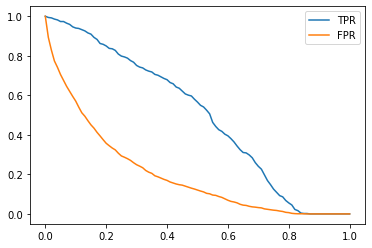

In [33]:
#plot the values
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.legend()

In [34]:
#get line, where difference between TPR and FPR is the biggest

#compute diff between tpr and fpr
#and add it to the df
df_scores['diff'] = df_scores.tpr - df_scores.fpr

In [35]:
#get row of df where diff is highest
df_scores.loc[df_scores['diff'] == df_scores['diff'].max()] 

,threshold,tp,fp,fn,tn,tpr,fpr,diff
37,0.37,341,258,145,1116,0.701646,0.187773,0.513873


in order to better understand the meaning of TPR and FPR,<br>
we compare it with 2 baseline models (random model & ideal model)

<b>Random Baseline Model</b>

In [36]:
#fix random seed for reproducibility
np.random.seed(1)
#generate array with random numbers between 0 and 1
#y_rand contains the "predictions of our model"
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [37]:
#calculate TPR and FPR at different thresholds

#generate function what takes in actual and predicted values
def tpr_fpr_dataframe(y_val, y_pred):
    #calculate confusion table for different thresholds
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    
    #convert confusion table numbers to dataframe and give columns a name
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    
    #calculate TPR & FPR
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [38]:
#use the function to calculate TPR and FPR for random model
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [39]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


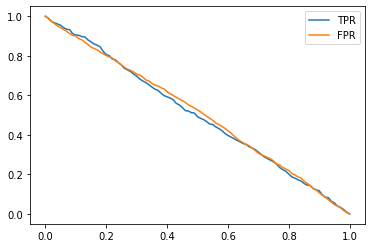

In [40]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
#see also page 154 for explanation

<b>findings of random baseline model:</b>
* at threshold of 0.0, every is regarded as churning (the values of the target<br>
variable cannot be below 0 --> so TPR and FPR is 100%
* at threshold of 0.4, TPR and FPR are 60%<br>
for TPR: TP is 60%, FN is 40%<br>
for FPR: FP is 60%, TN is 40%
* at threshold of 1.0, everybody is regarded as non-churning<br>
so TPR and FPR are 0%<br>
for TPR: we have 0% TP and 100% FN<br>
for FPR: we have 0% FP and 100% TN

<b>The ideal (ranking) model</b><br>
That model always makes the right decisions.<br>
Churning customers always have higher scores than non-churning ones.<br>
--> predicted probability for all churned ones should be higher than predicted probabilty<br>
for non-churned ones

<img src="data/pic-15.png" width=400 align="left">

In [41]:
#generate ideal predictions
#generate array with fake target variables, that are already ordered
#it firstly only contains 0's, then it only contains 1's

#calculate number of negative and positive examples in dataset
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

#generate array that firstly repeates 0s num_neg number of times,
#then generates 1s repeated num_pos number of times
y_ideal = np.repeat([0,1], [num_neg, num_pos])

#generate "predicitions of the model"：numbers that grow 
#from 0 in first cell to 1 in last cell
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

#calculate TPR and FPR for this model
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

In [42]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


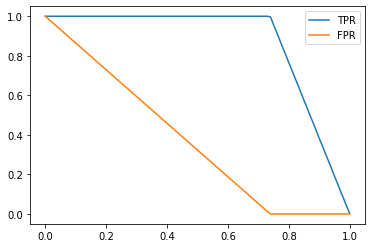

In [43]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

<b>findings from above plot</b>
* for threshold lower than 0.74, the model always correctly classifies<br>
churning customers, that's why TPR stays at 100%
* on other side, we incorrectly classify non-churning customers as churning (FP),<br>
with a growing threshold, the FPR goes down (so fewer and fewer non-churning<br>
customers are predicted as churning
* at threshold of 0.74, we have ideal situation: all churning customers are<br>
are classified as churning (TPR = 100) and all non-churning customers <br>
are classified as non-churning (FPR = 0)
* above 0.74, we always correctly identify all non-churning customers<br>
(FPR stays at 0) but we incorrectly classify more and more churning customers<br>
as non-churning (TPR goes down)

<img src="data/pic-16.png" width=400 align="left">

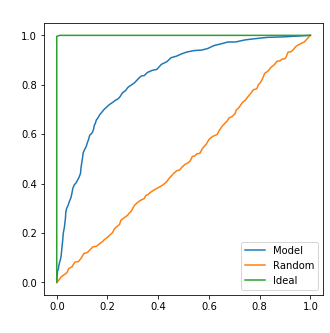

In [49]:
#create the ROC curve

#prepare plot square
plt.figure(figsize=(5, 5))
#plot ROC curve for the model
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
#plot ROC curve for the random baseline model
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
#plot ROC curve for the ideal ranking model
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')

plt.legend()


<b>Findings from above plot:</b>
* in the upper left corner is our ideal spot (TPR = 100, FPR = 0)
* our curve should ideally reach this spot
* we can simplify the plot (see below)

Text(0.5, 1.0, 'ROC Curve')

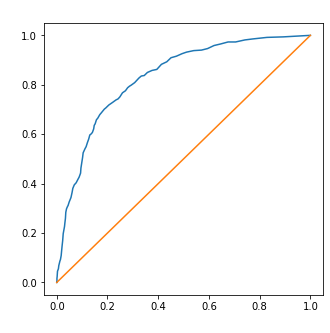

In [50]:
#prepare plot square
plt.figure(figsize=(5, 5))
#plot ROC curve for the model
plt.plot(df_scores.fpr, df_scores.tpr)
#draw a diagonal
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')


Text(0.5, 1.0, 'ROC Curve')

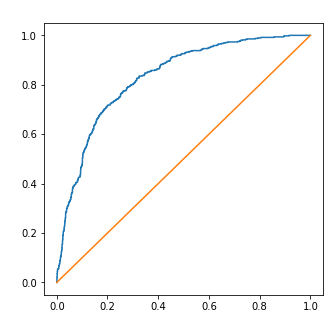

In [53]:
#use the roc_curve function to simplify your live
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')


